# VAE를 이용한 생성 모델
- Variational Autoencoder은 오코인코더를 개선하여 평균과 표준편차 두개의 성분을 나타내는 두개의 임베딩 벡터를 생성하게 한다
- 이를 이용하면 더 다양한 출력을 생성할 수 있다
- 새로운 분자의 구조를 생성하는 모델에 적용할 수 있다
- 분자 표현으로 SMILES를 사용하며 새로운 SMILES를 얻는다
 - MolrculeNet이 제공하는 SMILES 데이터셋 MUV 사용 (약 90000개 제공)
 - Maximum Unbiased Validation(MUV) - 17개의 태스크 포함
- [VAE 소개](https://towardsdatascience.com/an-introduction-to-variational-auto-encoders-vaes-803ddfb623df)

In [1]:
!pip install DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 15.6 MB/s 
     |████████████████████████████████| 29.5 MB 1.2 MB/s 


In [2]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [3]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

# 모델 만들기
# AspuruGuzikAutoEncoder: 인코더는 합성곱신경망을, 디코더는 순환신경망을 사용
# 학습속도를 조절하기 위해서 ExponentialDecay를 사용한다
# 0.001에서 시작하고 이포크마다 0.95배로 감소시킨다

from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae', 
                batch_size=batch_size, learning_rate=learning_rate)

# 시퀀스 생성 함수 정의

def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

# AspuruGuzikAutoEncoder이 제공하는 자체 학습 함수 (이포크수 지정)

model.fit_sequences(generate_sequences(50)) # 50 이포크 수


In [4]:
# 학습된 모델을 이용하여 새로운 분자를 만든다
# 모델에 들어가는 벡터의 크기를 지정한다 (예: 196)
# 벡터를 1000개 생성하겠다
# 생성된 분자들중 유효한 SMILES를 걸러내기 위해서 RDKit의 MolFromSmiles를 사용한다

from rdkit import Chem
predictions = model.predict_from_embeddings(np.random.normal(size=(1000,196)))
molecules = []
for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)
print()
print('Generated molecules:')
for m in molecules:
  print(m)


Generated molecules:
C=C1cccccccccccccccccccccccccccccccccccccccc1


In [5]:
molecules

['C=C1cccccccccccccccccccccccccccccccccccccccc1']

## 생성된 SMILES 들에 대해서 유효하지 않거나 약물로서 가치가 없는 분자를 걸러내야 한다
- 제거하고 싶은 분자가 있는지 찾는다
- MolFromSmiles()을 사용해 SMILES 문자열들을 분자 객체로 변환한다
- 분자의 크기를 확인한다 (10보다 작으면 상호작용에 필요한 에너지가 불충분하고, 50 이상이면 분자의 용해도가 너무 낮아 문제가 된다)
- 수소를 제외한 분자의 크기를 GetNumAtoms()로 얻는다
- 약물과 얼마나 유사한지를 판단하기 위해서 QED(Quantitave Estimate of Drugness)를 많이 사용한다
 - QED: 계산된 속성 집합과 판매된 약물의 동일한 특성 분포를 정량화 한 것 (Richard Bickerton 이 제안)
 - 1에 가까울수록 기존의 약물과 유사하다고 본다
 - QED > 0.5 인 분자만 고른 후 결과를 시각화 한다

In [6]:
from rdkit import Chem
molecules_new = [Chem.MolFromSmiles(x) for x in molecules]
# moleculs_new = [Chem.MolFromSmiles(x) for x in smlies_list]
print(sorted(x.GetNumAtoms() for x in molecules_new))

[42]


In [7]:
good_mol_list = [x for x in molecules_new if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

1


In [8]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]

In [9]:
qed_list

[0.2833590225259558]

In [10]:
final_mol_list = [(a,b) for a,b in zip(good_mol_list, qed_list) if b > 0.3] # 0.5를 낮춤
final_mol_list

[]

In [11]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(
    [x[0] for x  in final_mol_list],
    molsPerRow = 3, useSVG=True,
    subImgSize = (250, 250),
    returnPNG=True,
    legends=[f"{x[1]:.2f}" for x in final_mol_list])


'</svg>\n'

참고:
https://www.rdkit.org/docs/GettingStartedInPython.html#drawing-molecules

In [13]:
good_mol_list

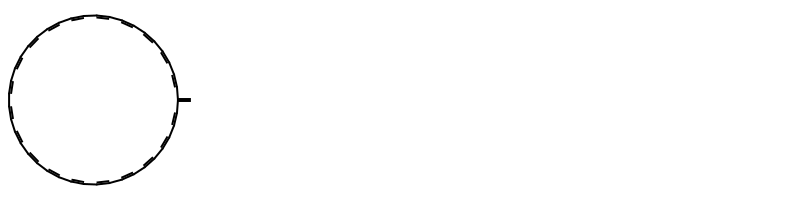

In [18]:
img=Draw.MolsToGridImage(good_mol_list,molsPerRow=4,subImgSize=(200,200))
                        #  legends=[x.GetProp("_Name") for x in good_mol_list])    
# img.save('images/cdk2_molgrid.aligned.o.png')
img

In [16]:
final_mol_list

[]

In [20]:
import joblib
joblib.dump(model, 'name1.pkl')
new_model = joblib.load('name1.pkl')

TypeError: ignored

In [21]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

TypeError: ignored